<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Entrenamiento y evaluación version 2</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Introdución](#1.-Introduccion)
2. [Importar librerias](#2.-Importar-librerias)
3. [Variables globales y funciones auxiliares](#3.-Variables-globales-y-funciones-auxiliares)
4. [Carga del dataframe](#4.-Carga-del-dataframe)
5. [Selección de las características](#5.-Nueva-seleccion-de-las-caracteristicas)
6. [Carga de los datos y división en entrenamiento y test](#6.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
7. [Evaluación modelos optimizados](#7.-Evaluacion-modelos-optimizados)
    * 7.1 [Clasificador Random Forest](#7.1-Clasificador-Random-Forest)
    * 7.2 [Clasificador MLP](#7.2-Clasificador-MLP)
    * 7.3 [Clasificador KNN](#7.3-Clasificador-KNN)
    * 7.4 [Clasificador GBC](#7.4-Clasificador-GBC)
    * 7.5 [Clasificador XGBoost](#7.5-Clasificador-XGBoost)
8. [Exportar CSV](#8.-Exportar-CSV)
    * 8.1 [Clasificador Random Forest](#8.1-Clasificador-Random-Forest)
    * 8.2 [Clasificador MLP](#8.2-Clasificador-MLP)
    * 8.3 [Clasificador KNN](#8.3-Clasificador-KNN)
    * 8.4 [Clasificador GBC](#8.4-Clasificador-GBC)
    * 8.5 [Clasificador XGBoost](#8.5-Clasificador-XGBoost)
    * 8.6 [Ensemble de los modelos por votacion](#8.6-Ensemble-de-los-modelos-por-votacion)

# 1. Introduccion

Este *notebook* se ha creado debido a que, después de entrenar todos los modelos y realizar sus respectivas subidas a Kaggle, nos encontramos estancados sin posibilidad de mejora. Como solución, se modificó la característica *Bank_Categorized_cod* para agrupar los bancos de una manera diferente. Además, a partir de este nuevo *Bank_Categorized_cod*, se aplicó *One Hot Encoding* con el fin de mejorar el rendimiento de los clasificadores.

Otra técnica que se modificó fue el uso de la PCA. Como se observó en las conclusiones del preprocesado, al utilizar PCA estábamos perdiendo algo de información. Por ello, en este notebook se optó por no emplearla y, en su lugar, intentar reducir la dimensionalidad de manera manual.

Respecto al *notebook* en sí, se da por supuesto el análisis exhaustivo realizado en *5_Entrenamiento_y_evaluacion_modelos.ipynb*, enfocándose en un análisis más directo en este *notebook*. Solamente se ha evaluado la matriz de confusión, el informe de clasificación, la curva de ROC y la AUC score. Además de que se ha evaluado directamente sobre el modelo optimizado.

Respecto a optimización de los modelos, se re-ejecutaron al tener distinto preprocesado y nuevas features. Además se re-ajustaron los hiperparámetros del GridSearch de cada modelo a la nueva situación. Además se evaluó solo con un cross validation igual a 3 para reducir los timepos de ejecución. También cabe mencionar que se decidio excluir del análisis LinearSVC por sus malos resultados, y se incluyo XGBoost en su lugar (la cual desconociamos al inicio de este trabajo).

# 2. Importar librerias

In [7]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 3. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [10]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [12]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

Función utilizada para estandarizar los datos en función del caso de preprocesado escogido.

In [14]:
def standard_data(case, X):
    
    if case in {1, 3, 5}:
        prep = StandardScaler().fit(X)
        X_scaled = prep.transform(X)
        
    elif case in {2, 4, 6}:
        prep = ColumnTransformer([
            ('numericas', StandardScaler(), numeric_vars)
        ], remainder='passthrough').fit(X) 
        X_scaled = prep.transform(X) 
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_scaled, prep

Función utilizada para muestrear los datos en función del caso de preprocesado escogido.

In [16]:
def resample_data(case, X, y, strategy_under, strategy_over, neighbors=5):
    
    if case in {1, 2}:
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X, y)
        
    elif case in {3, 4}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_resampled, y_resampled = unsamp.fit_resample(X, y)
        
    elif case in {5, 6}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_undersampled, y_undersampled = unsamp.fit_resample(X, y)
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X_undersampled, y_undersampled)
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_resampled, y_resampled

# 4. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [19]:
url = "formated/train_exportado_v2.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [21]:
url = "formated/test_exportado_v2.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 5. Nueva seleccion de las caracteristicas

Al eliminar la PCA se busco reducir la dimensionalidad manualmente. Para ello, se realizaron pruebas rápidas de los resultados tanto en local, observando el informe de clasificación, como sobre Kaggle, viendo el score obtenido.

Además se buscó eliminar aquellas características cuya información se encontrará redundada, es decir, durante la limpieza de los datos se crearon nuevas caracteristicas a partir de otras mediante diferentes transformaciones. Esto resultaba que si observabamos la matriz de correlaciones estuviesen muy relacionadas linealmente y que tuviesen una correlación muy similar con respecto *Accept*.

En definitiva se eliminaron las siguientes características:
* CreateJob: información ya incluida en CreateJob_Binary, en la que nos fijamos solamente si se crea o no empleo y no tanto en la cantidad.
* RetainedJob: información ya incluida en RetainedJob_Binary, en la que nos fijamos solamente si se crea o no empleo y no tanto en la cantidad.
* Bank_Categorized_cod: información ya incluida tras el One Hot Encoding.
* BankState_Categorized_cod: información ya incluida tras el One Hot Encoding.
* ApprovalFY_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, ApprovalFY.
* NoEmp_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, NoEmp.
* DisbursementGross_Grouped_cod: no se obtuvo una mejora significativa respecto a la característica base numerica, DisbursementGross.

In [24]:
selected_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',
    
    # Características temporales
    'ApprovalDate_quarter', 'DisbursementDate_quarter', 

    # Características relacionadas con Bank tras un One Hot Encoding
    'Bank_CAPITAL ONE NATL ASSOC', 'Bank_CITIZENS BANK NATL ASSOC',
    'Bank_COMMUNITY CAP. DEVEL CORP', 'Bank_FIFTH THIRD BANK',
    'Bank_FIRSTMERIT BANK, N.A.', 'Bank_HAMILTON CNTY DEVEL COMPANY IN',
    'Bank_JPMORGAN CHASE BANK NATL ASSOC', 'Bank_KEYBANK NATIONAL ASSOCIATION', 
    'Bank_PNC BANK, NATIONAL ASSOCIATION', 'Bank_THE HUNTINGTON NATIONAL BANK',
    'Bank_U.S. BANK NATIONAL ASSOCIATION', 'Bank_WELLS FARGO BANK NATL ASSOC', 
    'Bank_Otros',

    # Características relacionadas con BankState tras un One Hot Encoding
    'BankState_CA', 'BankState_DE', 'BankState_IL', 'BankState_IN',
    'BankState_OH', 'BankState_Otros', 'BankState_RI', 
    'BankState_SD', 'BankState_VA',
]

De las cuales, numéricas son las siguientes:

In [26]:
numeric_vars = ['ApprovalFY', 'NoEmp', 'DisbursementGross']

# 6. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [29]:
X = df[selected_features] 
y = df['Accept'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [33]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 7. Evaluacion modelos optimizados

Como ocurría en el anterior *notebook* se dejan las celdas de optimización en formato *Raw* debido a sus largas duraciones de ejecución.

## 7.1 Clasificador Random Forest

### 7.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [39]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [41]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [43]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [45]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

In [47]:
X_test_scaled = prep.transform(X_test)

### 7.1.2 Optimizacion

Se volvió a evaluar la profundidad media de los arboles y vimos que no existía una muestra significativa, por ello el únco hiperparámetro que hacia falta modificar era *max_features*, al haber pasado de las 17 componentes u 11 componentes (dependiendo del caso) tras PCA a las 32 características actuales.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.1.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion y entrenamiento

Definimos los mejores parámetros.

In [56]:
params_final_Forest = {
    'class_weight': 'balanced_subsample',
    'criterion': 'log_loss',
    'max_depth': 25,
    'max_features': 8,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 200,
    'n_jobs': -1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [58]:
final_Forest = RandomForestClassifier(**params_final_Forest)

Entrenamos el modelo.

In [60]:
final_Forest.fit(X_resampled, y_resampled)

predicted_For_opt = final_Forest.predict(X_test_scaled)
expected_For_opt = y_test

#### - Matriz de confusion y F-score

Se obtiene la matriz de confusión y el informe de clasificación.

In [63]:
print(confusion_matrix(expected_For_opt, predicted_For_opt))

[[ 535  215]
 [1048 2717]]


In [64]:
print(classification_report(expected_For_opt, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.34      0.71      0.46       750
           1       0.93      0.72      0.81      3765

    accuracy                           0.72      4515
   macro avg       0.63      0.72      0.64      4515
weighted avg       0.83      0.72      0.75      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. Además se obtiene una AUC score ligeramente superior a 0.71, pasando de una calificación *D* a una calificación *C*.

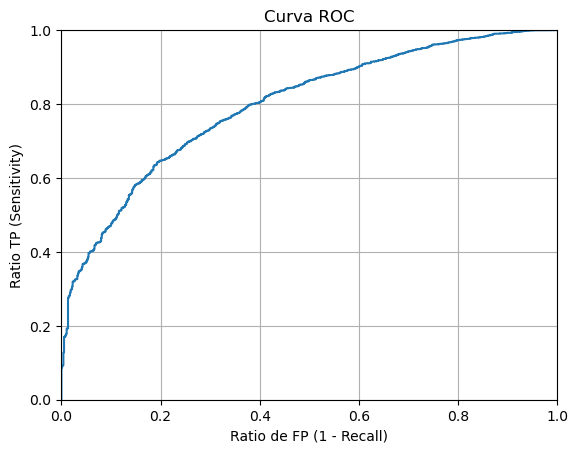

In [67]:
y_pred_prob_Forest = final_Forest.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [68]:
thresholds

array([       inf, 0.99986182, 0.99979485, ..., 0.03557262, 0.03473928,
       0.01377344])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

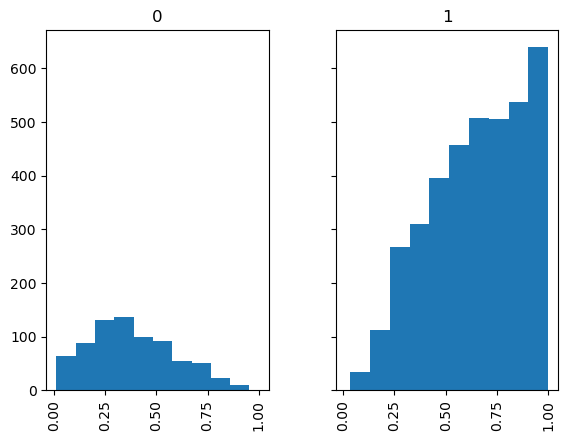

In [69]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [70]:
op_thres_Random = 0.3

evaluate_threshold(op_thres_Random)

Sensitivity: 0.9104913678618858
Recall: 0.3813333333333333


In [71]:
probs_For_opt = final_Forest.predict_proba(X_test_scaled)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= op_thres_Random).astype(int) 

In [72]:
print(confusion_matrix(expected_For_opt, pred_thres_For_opt))

[[ 285  465]
 [ 337 3428]]


In [73]:
print(classification_report(expected_For_opt, pred_thres_For_opt))

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       750
           1       0.88      0.91      0.90      3765

    accuracy                           0.82      4515
   macro avg       0.67      0.65      0.66      4515
weighted avg       0.81      0.82      0.82      4515



In [74]:
print(roc_auc_score(expected_For_opt, predicted_For_opt))

0.7174900398406374


## 7.2 Clasificador MLP

### 7.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [78]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [80]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [82]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [84]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

In [86]:
X_test_scaled = prep.transform(X_test)

### 7.2.2 Optimizacion

No se vio necesario modificar los hiperparámetros de este caso, simplemente se eliminaron algunas posibilidades entre las *hidden_layers* al ver que no terminaban de funcionar en el anterior *notebook*.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.2.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion y entrenamiento

Definimos los mejores parámetros.

In [95]:
params_final_Mlp = {
    'activation': 'tanh', 
    'alpha': 0.01, 
    'batch_size': 600,
    'hidden_layer_sizes': (100, 50, 25), 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.01, 
    'solver': 'adam',
    'max_iter': 1000, 
    'early_stopping': True, 
    'validation_fraction': 0.15, 
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [97]:
final_Mlp = MLPClassifier(**params_final_Mlp)

Entrenamos el modelo.

In [99]:
final_Mlp.fit(X_resampled, y_resampled)

predicted_MLP_opt = final_Mlp.predict(X_test_scaled)
expected_MLP_opt = y_test

#### - Matriz de confusion y F-score

Se obtiene la matriz de confusión y el informe de clasificación.

In [102]:
print(confusion_matrix(expected_MLP_opt, predicted_MLP_opt))

[[ 330  420]
 [ 474 3291]]


In [103]:
print(classification_report(expected_MLP_opt, predicted_MLP_opt))

              precision    recall  f1-score   support

           0       0.41      0.44      0.42       750
           1       0.89      0.87      0.88      3765

    accuracy                           0.80      4515
   macro avg       0.65      0.66      0.65      4515
weighted avg       0.81      0.80      0.80      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. En cambio, la AUC score se mejora de 0.61 a 0.65, pero no se llega al siguiente intervalo de clasificación (es decir, sigue siendo una *D*).

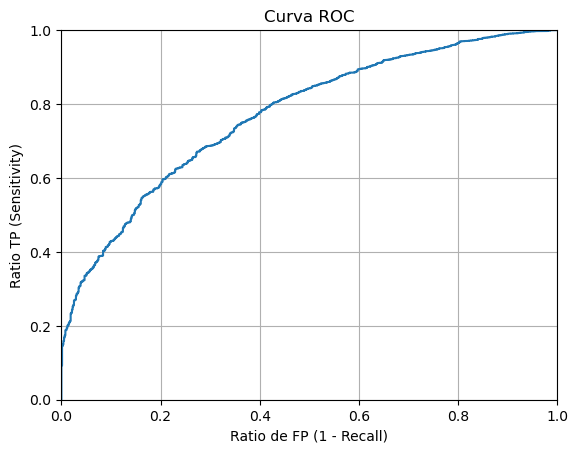

In [106]:
y_pred_prob_MLP = final_Mlp.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_MLP)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [107]:
thresholds

array([       inf, 0.99425738, 0.97610623, ..., 0.15548736, 0.15443916,
       0.13764927])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

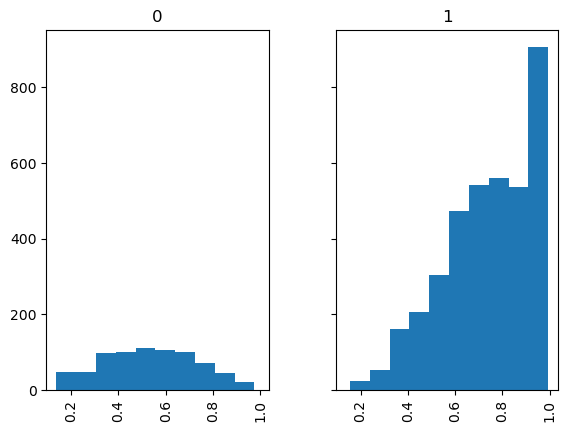

In [108]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_MLP, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [109]:
op_thres_MLP = 0.4

evaluate_threshold(op_thres_MLP)

Sensitivity: 0.9407702523240372
Recall: 0.272


In [110]:
probs_MLP_opt = final_Forest.predict_proba(X_test_scaled)[:, 1]  
pred_thres_MLP_opt = (probs_MLP_opt >= op_thres_MLP).astype(int) 

In [111]:
print(confusion_matrix(expected_MLP_opt, pred_thres_MLP_opt))

[[ 434  316]
 [ 652 3113]]


In [112]:
print(classification_report(expected_MLP_opt, pred_thres_MLP_opt))

              precision    recall  f1-score   support

           0       0.40      0.58      0.47       750
           1       0.91      0.83      0.87      3765

    accuracy                           0.79      4515
   macro avg       0.65      0.70      0.67      4515
weighted avg       0.82      0.79      0.80      4515



In [113]:
print(roc_auc_score(expected_MLP_opt, predicted_MLP_opt))

0.6570517928286852


#### - Curva de pérdidas y scores de validación

Se observa que se ejecutan muchas menos iteraciones debido al early_stopped. El motivo es que esta converguiendo las perdidas mucho más rapido. Esto supone que las *validation_scores_* sean mucho más variables al estar siendo analizado en menos iteraciones.

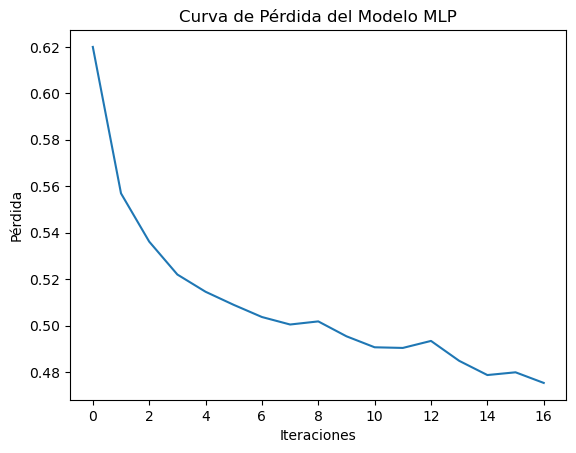

In [116]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

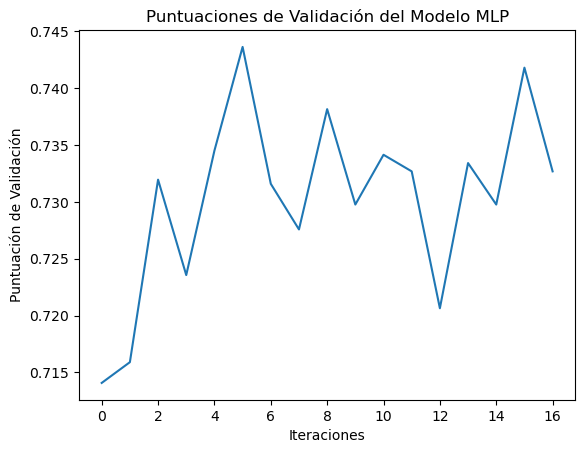

In [117]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

## 7.3 Clasificador KNN

### 7.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [121]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [123]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [125]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [127]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

In [129]:
X_test_scaled = prep.transform(X_test)

### 7.3.2 Optimización

No se vio necesario modificar los hiperparámetros de este caso, simplemente se añadieron más vecinos por si estabamos poniendo un límite inferior muy bajo.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.3.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion y entrenamiento

Definimos los mejores parámetros.

In [138]:
params_final_KNN = {
    "n_neighbors": 17, 
    "leaf_size": 10, 
    "metric": "minkowski", 
    "p": 3, 
    "weights": "uniform", 
    "algorithm": "auto"
}

Definimos el modelo desagregando el diccionario.

In [140]:
final_KNN = KNeighborsClassifier(**params_final_KNN)

Entrenamos el modelo.

In [142]:
final_KNN.fit(X_resampled, y_resampled)

predicted_KNN_opt = final_KNN.predict(X_test_scaled)
expected_KNN_opt = y_test

#### - Matriz de confusion y F-score

Se obtiene la matriz de confusión y el informe de clasificación.

In [145]:
print(confusion_matrix(expected_KNN_opt, predicted_KNN_opt))

[[ 491  259]
 [1094 2671]]


In [146]:
print(classification_report(expected_KNN_opt, predicted_KNN_opt))

              precision    recall  f1-score   support

           0       0.31      0.65      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515
   macro avg       0.61      0.68      0.61      4515
weighted avg       0.81      0.70      0.74      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. Además se obtiene una AUC score ligeramente superior, aunque de mismo valor de clasificación, una *D*.

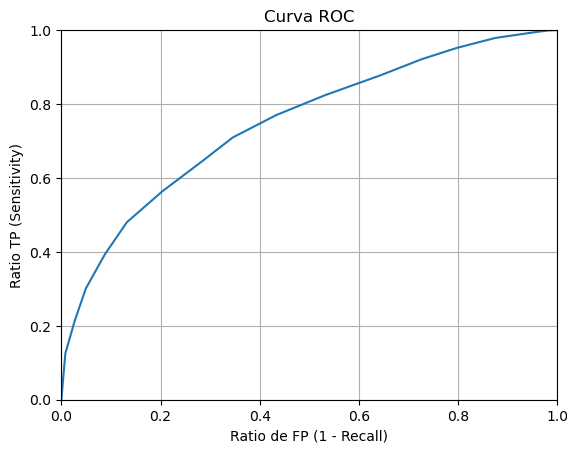

In [149]:
y_pred_prob_KNN = final_KNN.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_KNN)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [150]:
thresholds

array([       inf, 1.        , 0.94117647, 0.88235294, 0.82352941,
       0.76470588, 0.70588235, 0.64705882, 0.58823529, 0.52941176,
       0.47058824, 0.41176471, 0.35294118, 0.29411765, 0.23529412,
       0.17647059, 0.11764706, 0.05882353, 0.        ])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

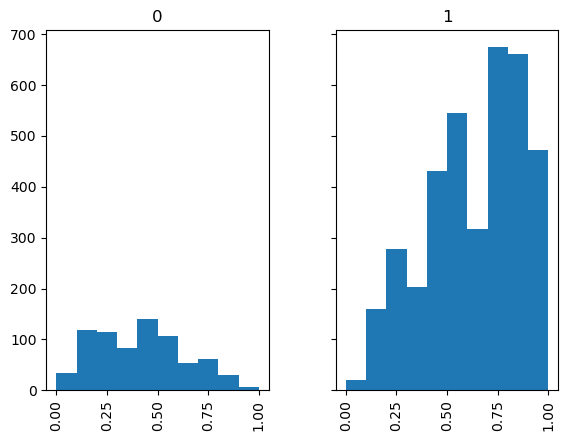

In [151]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_KNN, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [152]:
op_thres_KNN = 0.4

evaluate_threshold(op_thres_KNN)

Sensitivity: 0.8241699867197875
Recall: 0.46799999999999997


In [153]:
probs_KNN_opt = final_KNN.predict_proba(X_test_scaled)[:, 1]  
pred_thres_KNN_opt = (probs_KNN_opt >= op_thres_KNN).astype(int) 

In [154]:
print(confusion_matrix(expected_KNN_opt, pred_thres_KNN_opt))

[[ 351  399]
 [ 662 3103]]


In [155]:
print(classification_report(expected_KNN_opt, pred_thres_KNN_opt))

              precision    recall  f1-score   support

           0       0.35      0.47      0.40       750
           1       0.89      0.82      0.85      3765

    accuracy                           0.77      4515
   macro avg       0.62      0.65      0.63      4515
weighted avg       0.80      0.77      0.78      4515



In [156]:
print(roc_auc_score(expected_KNN_opt, predicted_KNN_opt))

0.6820478087649403


## 7.4 Clasificador GBC

### 7.4.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [160]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [162]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [164]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [166]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

In [167]:
X_test_scaled = prep.transform(X_test)

### 7.4.2 Optimizacion

No se vio necesario modificar los hiperparámetros de este caso.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.4.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros.

In [176]:
params_final_GBC = {
    'criterion': 'squared_error',
    'max_depth': 5,
    'max_features': 8,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 300,
    'subsample': 1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [178]:
final_GBC = GradientBoostingClassifier(**params_final_GBC)

Entrenamos el modelo.

In [180]:
final_GBC.fit(X_resampled, y_resampled)

predicted_GBC_opt = final_GBC.predict(X_test_scaled)
expected_GBC_opt = y_test

#### - Matriz de confusion y F-score

Se obtiene la matriz de confusión y el informe de clasificación.

In [183]:
print(confusion_matrix(expected_GBC_opt, predicted_GBC_opt))

[[ 523  227]
 [ 994 2771]]


In [184]:
print(classification_report(expected_GBC_opt, predicted_GBC_opt))

              precision    recall  f1-score   support

           0       0.34      0.70      0.46       750
           1       0.92      0.74      0.82      3765

    accuracy                           0.73      4515
   macro avg       0.63      0.72      0.64      4515
weighted avg       0.83      0.73      0.76      4515



#### - ROC y AUC

La distribución de probabilidades de los 0s y 1s esta más polarizada permitiendo ajustar mejor el threshold. Además se obtiene una AUC score ligeramente superior, aunque suficiente como para aumentar el valor de clasificación, a una *C*.

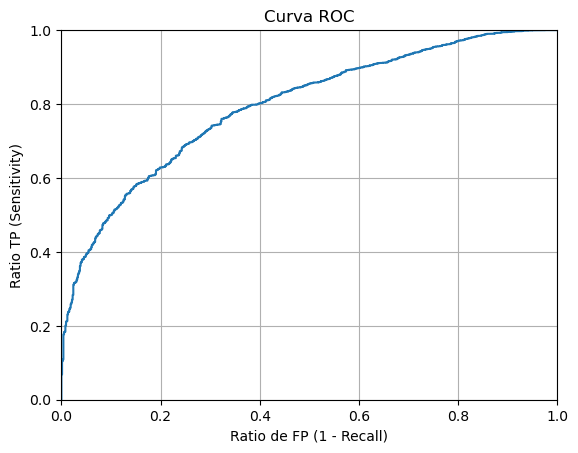

In [187]:
y_pred_prob_GBC = final_GBC.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_GBC)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [188]:
thresholds

array([       inf, 0.99969896, 0.98541557, ..., 0.02112195, 0.02051061,
       0.00311123])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

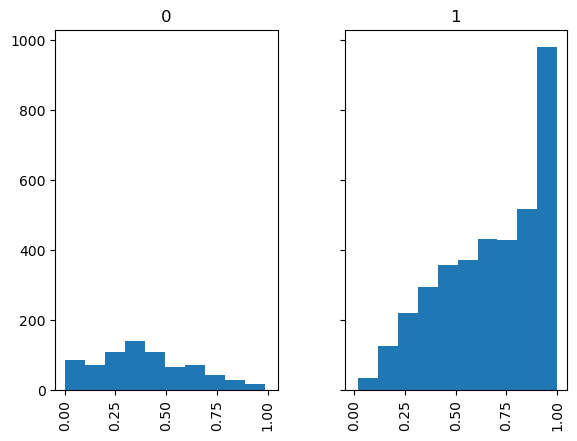

In [189]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_GBC, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [190]:
op_thres_GBC = 0.4

evaluate_threshold(op_thres_GBC)

Sensitivity: 0.8284196547144754
Recall: 0.556


In [191]:
probs_GBC_opt = final_GBC.predict_proba(X_test_scaled)[:, 1]  
pred_thres_GBC_opt = (probs_GBC_opt >= op_thres_GBC).astype(int) 

In [192]:
print(confusion_matrix(expected_GBC_opt, pred_thres_GBC_opt))

[[ 417  333]
 [ 641 3124]]


In [193]:
print(classification_report(expected_GBC_opt, pred_thres_GBC_opt))

              precision    recall  f1-score   support

           0       0.39      0.56      0.46       750
           1       0.90      0.83      0.87      3765

    accuracy                           0.78      4515
   macro avg       0.65      0.69      0.66      4515
weighted avg       0.82      0.78      0.80      4515



In [194]:
print(roc_auc_score(expected_GBC_opt, predicted_GBC_opt))

0.7166613545816733


## 7.5 Clasificador XGBoost

### 7.5.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [198]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [200]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [202]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [204]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

In [205]:
X_test_scaled = prep.transform(X_test)

### 7.5.2 Optimizacion

No se vio necesario modificar los hiperparámetros de este caso.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.5.3 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros.

In [2660]:
params_final_XG = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': 3,
    'eta': 0.2,
    'n_estimators': 200,
    'subsample': 1.0,
    'scale_pos_weight': 1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [2663]:
final_XG = XGBClassifier(**params_final_XG)

Entrenamos el modelo.

In [2573]:
final_XG.fit(X_resampled, y_resampled)

predicted_XG_opt = final_XG.predict(X_test_scaled)
expected_XG_opt = y_test

#### - Matriz de confusion y F-score

Se obtiene la matriz de confusión y el informe de clasificación.

In [2576]:
print(confusion_matrix(expected_GBC_opt, predicted_GBC_opt))

[[ 523  227]
 [ 994 2771]]


In [2577]:
print(classification_report(expected_GBC_opt, predicted_GBC_opt))

              precision    recall  f1-score   support

           0       0.34      0.70      0.46       750
           1       0.92      0.74      0.82      3765

    accuracy                           0.73      4515
   macro avg       0.63      0.72      0.64      4515
weighted avg       0.83      0.73      0.76      4515



#### - ROC y AUC

Se puede ajustar bien el threshold debido a tener un buen f1 score en 0s por defecto, permitiendo reducir dicho valor para intentar aumentar el accuracy. Respecto al AUC score se obtiene un valor de 0.71, es decir, una calificación *C*.

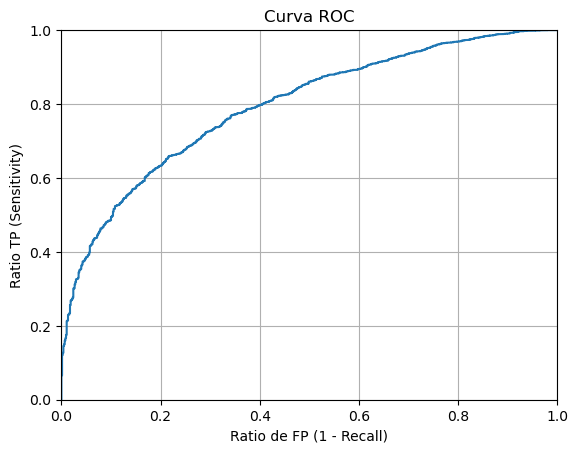

In [2580]:
y_pred_prob_XG = final_XG.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_XG)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [2581]:
thresholds

array([       inf, 0.9999144 , 0.9726599 , ..., 0.01708872, 0.01654997,
       0.0033459 ], dtype=float32)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

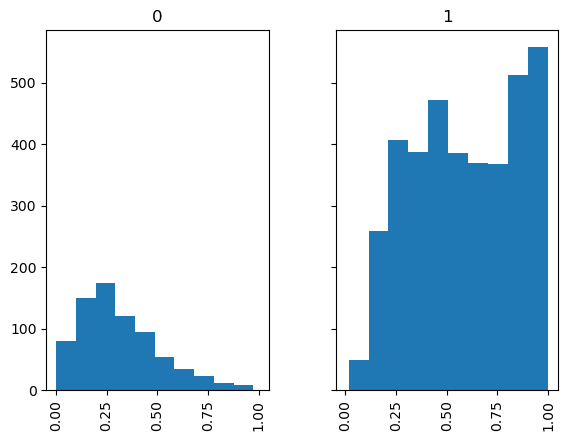

In [2582]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_XG, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [2583]:
op_thres_XG = 0.3

evaluate_threshold(op_thres_XG)

Sensitivity: 0.8228419654714475
Recall: 0.5573333333333333


In [2584]:
probs_XG_opt = final_XG.predict_proba(X_test_scaled)[:, 1]  
pred_thres_XG_opt = (probs_XG_opt >= op_thres_XG).astype(int) 

In [2585]:
print(confusion_matrix(expected_XG_opt, pred_thres_XG_opt))

[[ 418  332]
 [ 666 3099]]


In [2586]:
print(classification_report(expected_XG_opt, pred_thres_XG_opt))

              precision    recall  f1-score   support

           0       0.39      0.56      0.46       750
           1       0.90      0.82      0.86      3765

    accuracy                           0.78      4515
   macro avg       0.64      0.69      0.66      4515
weighted avg       0.82      0.78      0.79      4515



In [232]:
print(roc_auc_score(expected_XG_opt, predicted_XG_opt))

0.7163957503320053


# 8. Exportar CSV

## 8.1 Clasificador Random Forest

### 8.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [1420]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [1423]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [1426]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [1429]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [1432]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.1.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [1436]:
final_Forest.fit(X_resampled_final, y_resampled_final)

probs_For_final = final_Forest.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.55).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [1438]:
df_accept_Random = pd.DataFrame(pred_thres_For_final, columns=['Accept'])

In [1439]:
df_id = df_test['id'].reset_index(drop=True)

In [1440]:
df_final_Random = pd.concat([df_id, df_accept_Random], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [1442]:
df_final_Random['Accept'].value_counts()

Accept
1    1737
0    1547
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [1449]:
df_final_Random.to_csv('./submit/random_v2.csv', index=False)

## 8.2 Clasificador MLP

### 8.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [1300]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [1303]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [1306]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [1309]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [1312]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.2.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades.

In [1336]:
final_Mlp.fit(X_resampled_final, y_resampled_final)

probs_Mlp_final = final_Mlp.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_Mlp_final = (probs_Mlp_final >= 0.55).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [1338]:
df_accept_Mlp = pd.DataFrame(pred_thres_Mlp_final, columns=['Accept'])

In [1339]:
df_id = df_test['id'].reset_index(drop=True)

In [1340]:
df_final_Mlp = pd.concat([df_id, df_accept_Mlp], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [1342]:
df_final_Mlp['Accept'].value_counts()

Accept
0    1883
1    1401
Name: count, dtype: int64

Comprobamos la curva de pérdidas y los scores de validación.

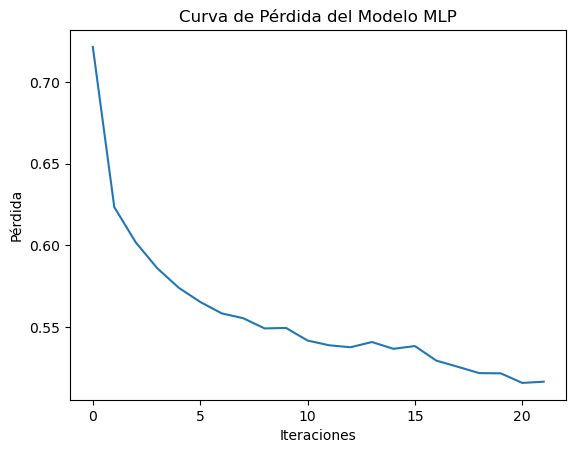

In [1349]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

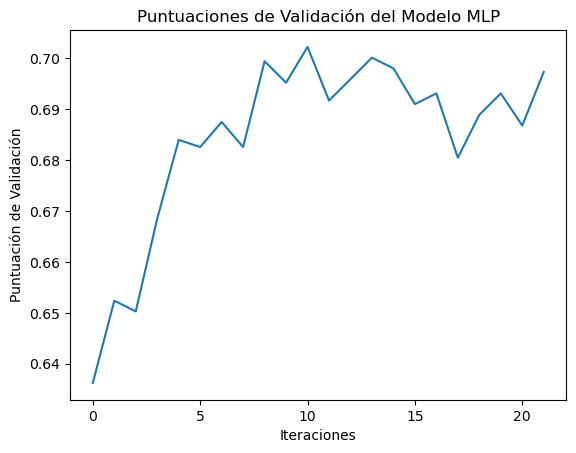

In [1351]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

Se transforma el *dataframe* a un archivo *CSV*.

In [1354]:
df_final_Mlp.to_csv('./submit/mlp_v2.csv', index=False)

## 8.3 Clasificador KNN

### 8.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [1793]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [1796]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [1799]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [1802]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [1805]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.3.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test.

In [1839]:
final_KNN.fit(X_resampled_final, y_resampled_final)

probs_KNN_final = final_KNN.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_KNN_final = (probs_KNN_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [1841]:
df_accept_KNN = pd.DataFrame(pred_thres_KNN_final, columns=['Accept'])

In [1842]:
df_id = df_test['id'].reset_index(drop=True)

In [1843]:
df_final_KNN = pd.concat([df_id, df_accept_KNN], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [1845]:
df_final_KNN['Accept'].value_counts()

Accept
1    2023
0    1261
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [1847]:
df_final_KNN.to_csv('./submit/knn_v2.csv', index=False)

## 8.4 Clasificador GBC

### 8.4.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [2149]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [2152]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [2155]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [2158]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [2161]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.4.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades.

In [2180]:
final_GBC.fit(X_resampled_final, y_resampled_final)

probs_GBC_final = final_GBC.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_GBC_final = (probs_GBC_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [2182]:
df_accept_GBC = pd.DataFrame(pred_thres_GBC_final, columns=['Accept'])

In [2183]:
df_id = df_test['id'].reset_index(drop=True)

In [2184]:
df_final_GBC = pd.concat([df_id, df_accept_GBC], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [2186]:
df_final_GBC['Accept'].value_counts()

Accept
1    1799
0    1485
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [2188]:
df_final_GBC.to_csv('./submit/gbc_v2.csv', index=False)

## 8.5 Clasificador XGBoost

### 8.5.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [2665]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [2668]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [2670]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [2674]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [2677]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.5.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test.

In [2681]:
final_XG.fit(X_resampled_final, y_resampled_final)

probs_XG_final = final_XG.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_XG_final = (probs_XG_final >= 0.55).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [2684]:
df_accept_XG = pd.DataFrame(pred_thres_XG_final, columns=['Accept'])

In [2686]:
df_id = df_test['id'].reset_index(drop=True)

In [2688]:
df_final_XG = pd.concat([df_id, df_accept_XG], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [2691]:
df_final_XG['Accept'].value_counts()

Accept
1    1952
0    1332
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [2694]:
df_final_XG.to_csv('./submit/xg.csv', index=False)

## 8.6 Ensemble de los modelos por votacion

### 8.6.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [3014]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [3017]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [3020]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [3023]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se preprocesa el conjunto de test.

In [3026]:
X_test_scaled_final = prep_final.transform(X_test_final)

### 8.6.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test. Se ha decidido no incluir en el ensemble el clasificador LinearSVC por sus malos resultados.

In [3077]:
voting_clf = VotingClassifier( 
    estimators=[
        ('RF', final_Forest),
        ('GBC', final_GBC),
        ('XG', final_XG),
    ],
    voting='soft',
    weights=[2, 1, 3],
    n_jobs=-1
)

In [3079]:
voting_clf.fit(X_resampled_final, y_resampled_final)

probs_Vote_final = voting_clf.predict_proba(X_test_scaled_final)[:, 1]  
pred_thres_Vote_final = (probs_Vote_final >= 0.45).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [3081]:
df_accept_vote = pd.DataFrame(pred_thres_Vote_final, columns=['Accept'])

In [3082]:
df_id = df_test['id'].reset_index(drop=True)

In [3083]:
df_final_vote = pd.concat([df_id, df_accept_vote], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [3085]:
df_final_vote['Accept'].value_counts()

Accept
1    1961
0    1323
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [3092]:
df_final_vote.to_csv('./submit/vote_v2.csv', index=False)